# Exploratory Visualization 

In [7]:
df = pd.read_csv("Data/cleaned_bike_data.csv")

In [8]:
# Datatype change 
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

columns_to_obj = ['start_station_id','end_station_id','bike_id'] 
for col in columns_to_obj:
    df[col]= df[col].astype(int)
    df[col]= df[col].astype(str)

## Univariate Exploration
Since the `Duration_sec` column is the only quantitave attributes, lets find some riding patterns. 

* **How long are people riding these bikes?** 

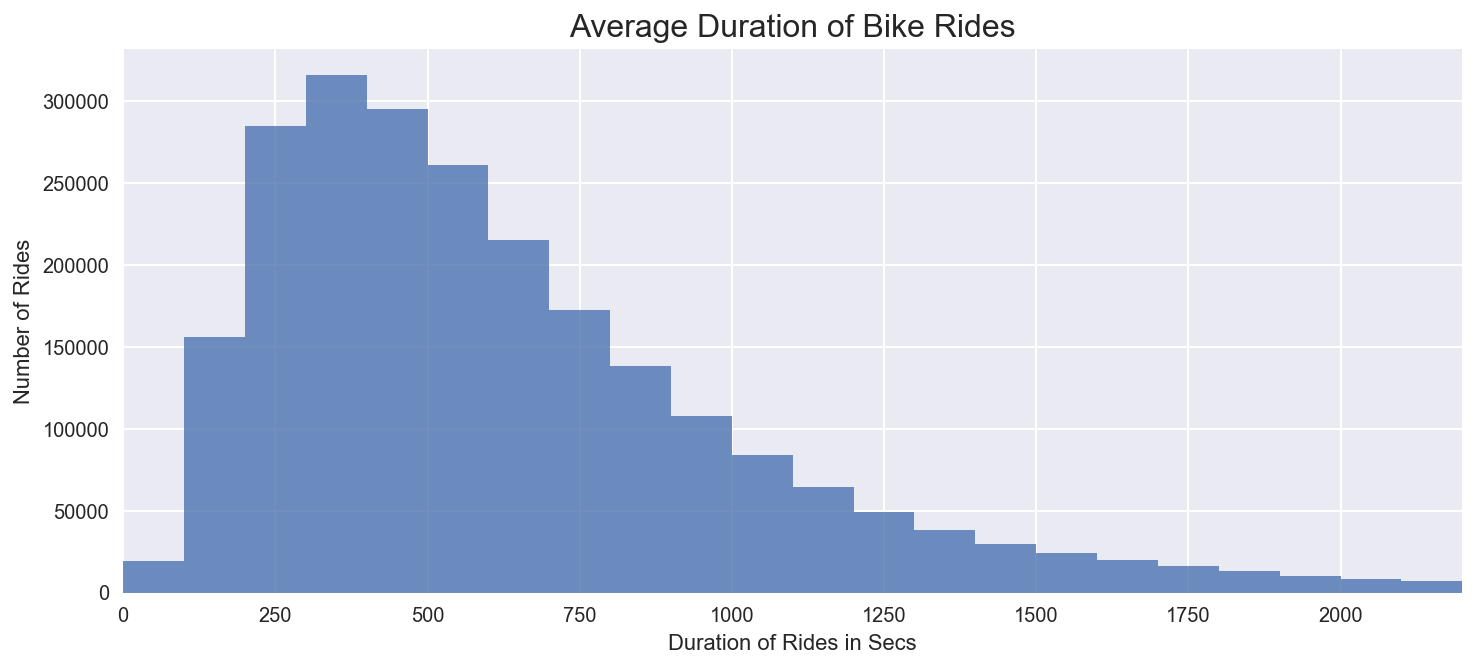

In [51]:
#Visualizing the data in a histogram
plt.figure(figsize= (12,5))
duration_bins = np.arange(0, df['duration_sec'].max() + 200, 100)
sns.distplot(df['duration_sec'], bins = duration_bins, kde = False, hist_kws = {'alpha' : 0.8});

plt.xlim(0, 2200);
plt.style.use('seaborn')
plt.title('Average Duration of Bike Rides', fontsize = 16)
plt.xlabel('Duration of Rides in Secs')
plt.ylabel('Number of Rides')
plt.style.use('seaborn');

- In this analysis we'd like to see the distribution of people riding bikes in secs. Since the distribution is right skewed here we set the top limit of 2200 secs to remove some outliers with extremely long riding time.   
- We can see tha the peak usesage falls in 250-740 secs which is around 4.5mins, so generally speaking, people like to use gobike for short routes.   

**What would be the distribution looks like if we use the log transformation? ** 

In [124]:
min_duration = df.query('duration_sec <=3000')['duration_sec'].min()
max_duration = df.query('duration_sec <=3000')['duration_sec'].max()

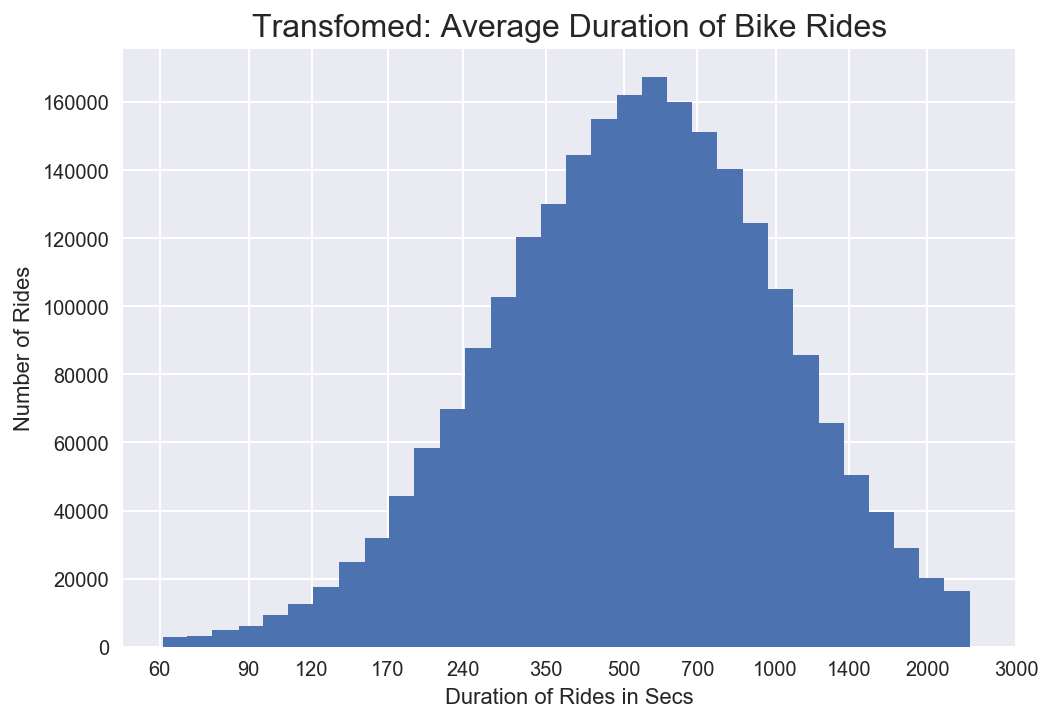

In [231]:
# Create bins
duration_bins = 10** np.arange( math.log10(min_duration),3+0.4, 0.05)
duration_bins = list(dict.fromkeys([math.trunc(x) for x in duration_bins]))

# Rename Ticks 
ticks = [60, 90, 120, 170, 240, 350, 500, 700, 1000, 1400, 2000, 3000 ]
labels = ['{}'.format(val) for val in ticks]

plt.hist(df.query('duration_sec <=3000')['duration_sec'] , bins = duration_bins);

plt.xscale('log')
plt.style.use('seaborn')
plt.title('Transfomed: Average Duration of Bike Rides', fontsize = 16)
plt.xlabel('Duration of Rides in Secs')
plt.ylabel('Number of Rides')
plt.xticks(ticks, labels); 

- From this log transformed plot, we can see that the duration of rides looks normal distribution with most of the rides fall under (350-1000 secs) which is reasonable for short distance ride.

**Where are top 15 places people like to take a ride? **

In [291]:
# Keep only the main address
df['start_station_name_abbr']=  df.start_station_name.apply(lambda x: x.split('(')[0])

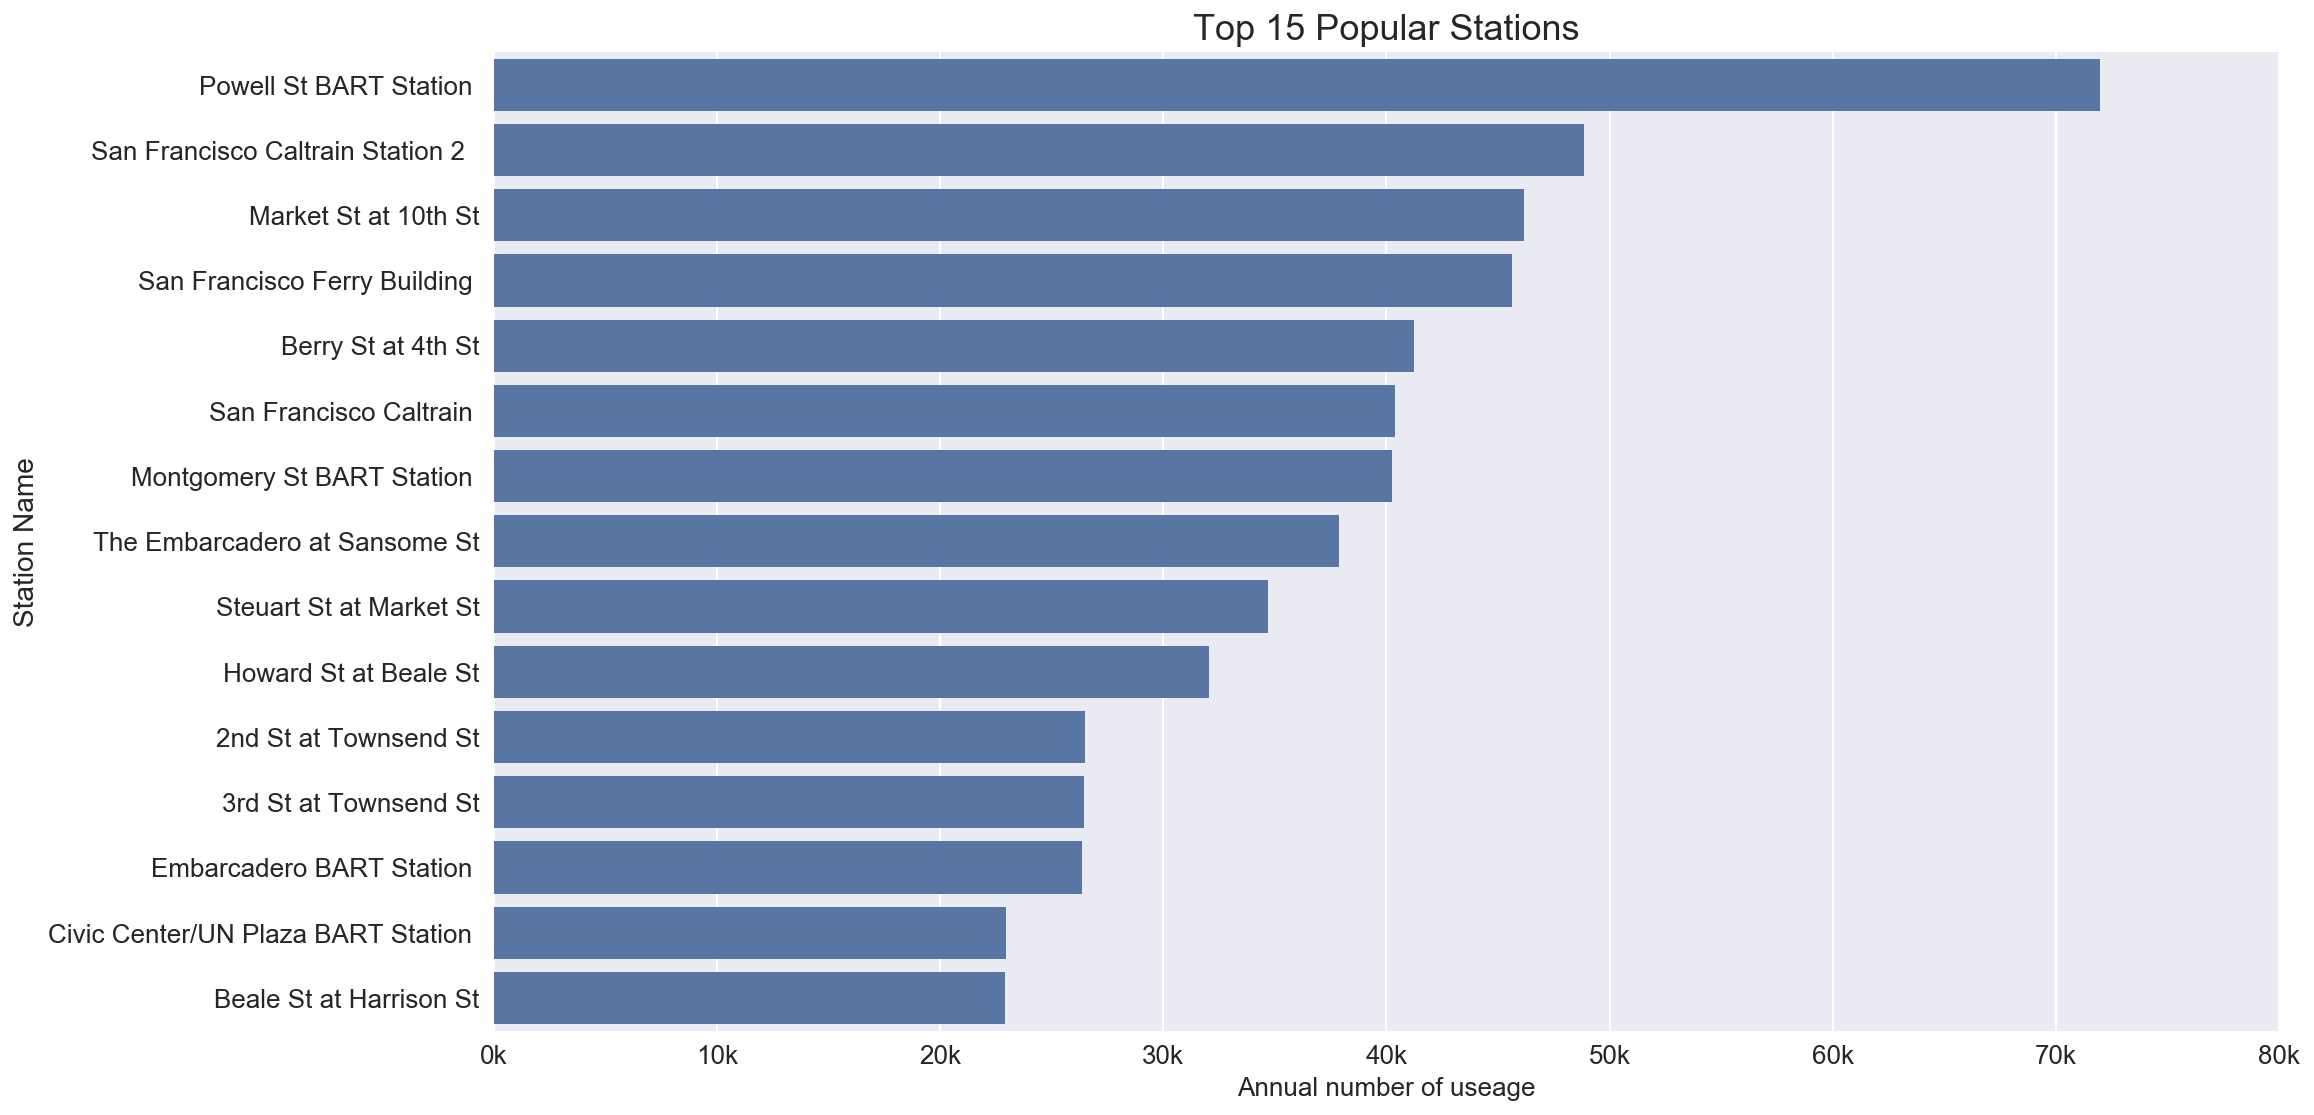

In [295]:
ticks= np.arange(0, 90000, 10000)
labels = ['{}k'.format(math.trunc(val/1000)) for val in ticks]

plt.figure(figsize=(16,9))
sns.countplot(data = df, y='start_station_name_abbr',
              order = df.start_station_name_abbr.value_counts()[:15].index, color= sns.color_palette()[0])
plt.xticks(ticks, labels,fontsize= 13)
plt.yticks(fontsize= 13)
plt.xlabel('Annual number of useage',fontsize= 13)
plt.ylabel('Station Name',fontsize= 14)
plt.title('Top 15 Popular Stations',fontsize= 18);

- Its unexpectly to see that many of start places are around Station (Caltrain, Bart Station). This finding isnt really surprising so lets see what are the proportion of commute ride (either start place or end place is station).  

**The proportion of Commute Rides? Any specific public transportation related to those commute rides?**

In [9]:
# Since Bay area has port, lets also count Ferry in
commute_keys = ['BART Station','Ferry','Caltrain Station']

In [10]:
commute_ride = [] 
check_start_station = df['start_station_name'].apply(lambda x: any([word in x for word in commute_keys]))
check_end_station = df['end_station_name'].apply(lambda x: any([word in x for word in commute_keys]))

In [11]:
def check_commute(start, end):
    commute_ride = [] 
    for i, j in zip(start,end):
        if i== True or j== True:
            commute_ride.append('Commute Ride')
        else:
            commute_ride.append('Normal Ride') 
    return commute_ride
df['commute_ride'] = check_commute(check_start_station, check_end_station)

In [12]:
# Get a detailed information to show which public transpotation that people like to take rides more
commute_info = []
df_commute = df.query('commute_ride == "Commute Ride"')

for idx, row in df_commute[['start_station_name','end_station_name']].iterrows():
    if ('BART Station' in row['start_station_name']) or ('BART Station' in row['end_station_name']):
        commute_info.append('BART Station')
    elif ('Ferry' in row['start_station_name']) or ('Ferry' in row['end_station_name']):
        commute_info.append('Ferry')
    else: 
        commute_info.append('Caltrain Station')
df_commute['commute_info'] = commute_info

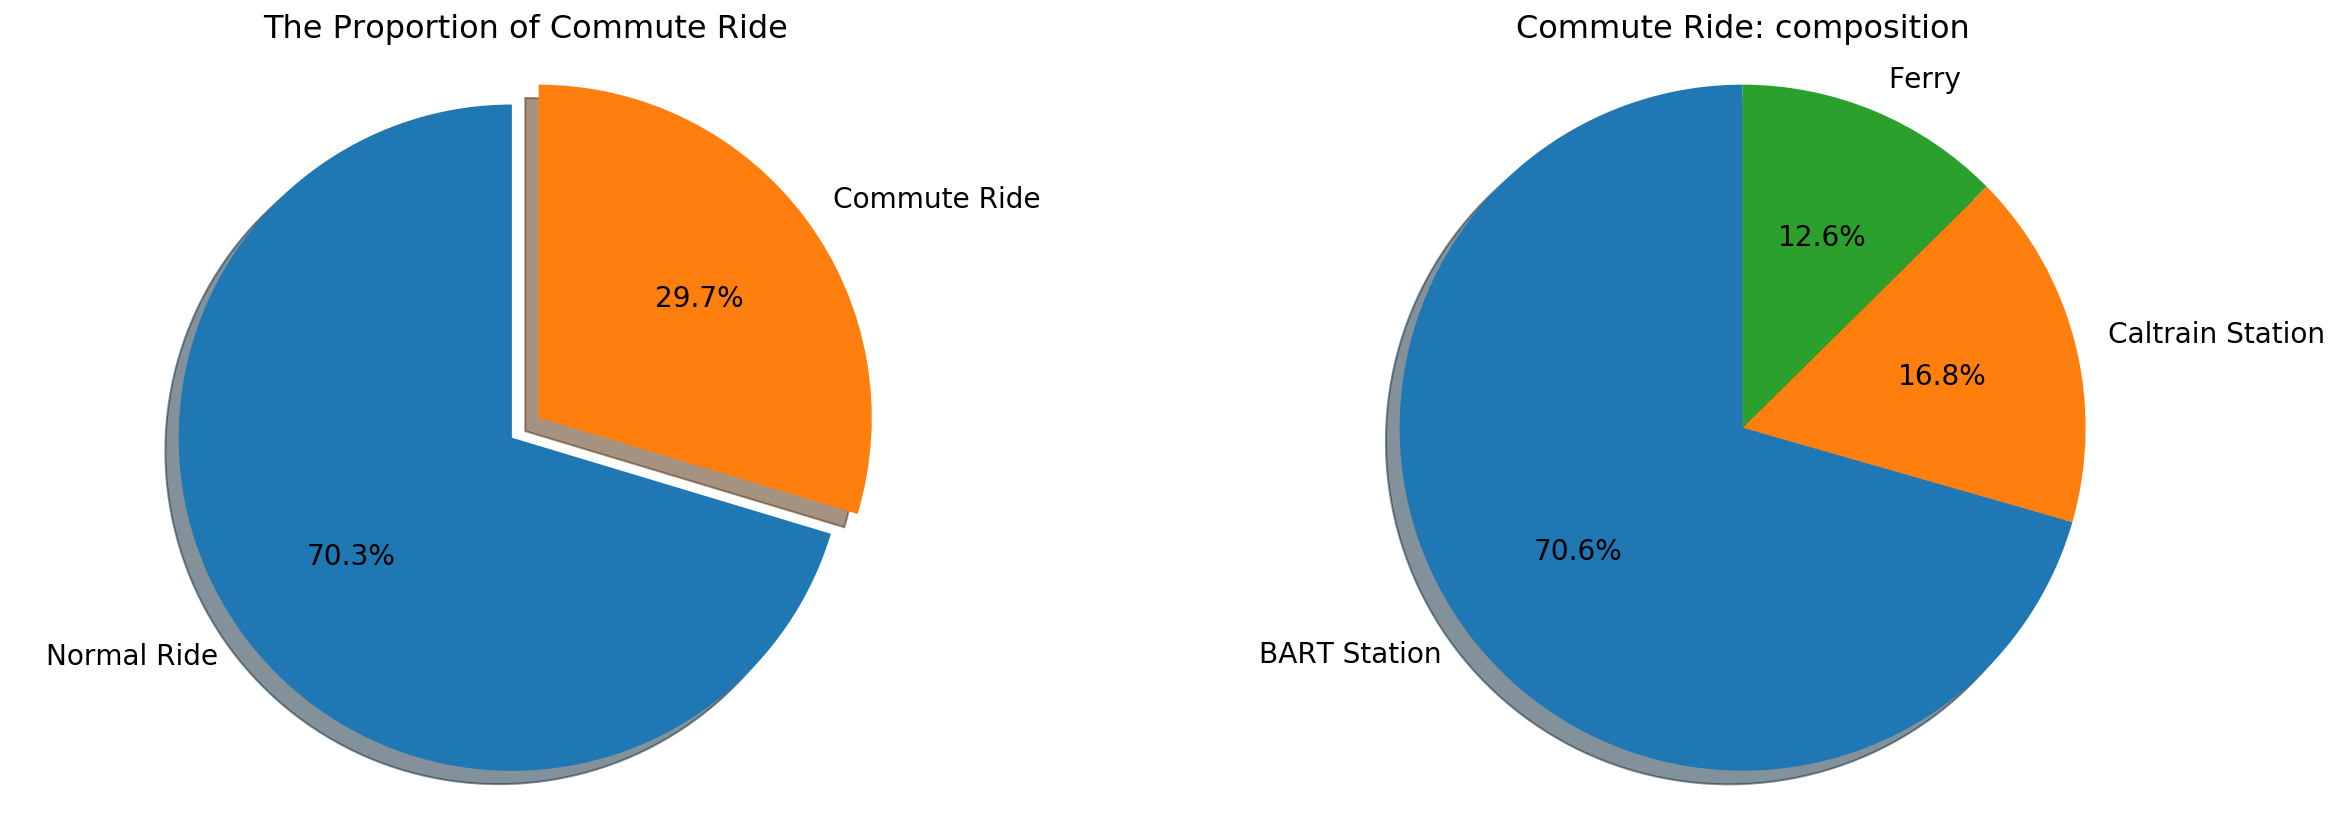

In [25]:
plt.figure(figsize = (20,7))
plt.subplot(1,2, 1)
labels = df.commute_ride.value_counts().index
sizes = (df.commute_ride.value_counts()/df.commute_ride.value_counts().sum()).tolist()
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, labels = labels,\
        autopct='%1.1f%%', explode = explode, shadow=True, startangle=90,textprops={'fontsize': 14})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('The Proportion of Commute Ride', fontsize= 16)

plt.subplot(1,2,2)
df_commute = df_commute[['commute_info']]
plt.pie((df_commute.commute_info.value_counts()/df_commute.commute_info.value_counts().sum()).tolist(),\
        labels = df_commute.commute_info.value_counts().index,\
        autopct='%1.1f%%', shadow=True, startangle=90,textprops={'fontsize': 14});
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Commute Ride: composition', fontsize= 16);

- Now we can see that, nearly 30% of the rides are communite rides related, and within these commute rides, people like to take ride to or out from Bart station.

## Bivariate Exploration
-After discovered some simple patterns of the ride, lets dive into the trip's information.

**When are most trips taken in terms of day of the week?**

In [27]:
df['start_weekday'] = df['start_time'].apply(lambda x: calendar.day_name[x.weekday()])
df['start_month'] = df['start_time'].apply(lambda x: x.month)
df['start_day'] = df['start_time'].apply(lambda x: x.day)
df['start_hour'] = df['start_time'].apply(lambda x: x.hour)
# Create ordinal of weekday 
ordinal_weekday= ['Monday', 'Tuesday','Wednesday',  'Thursday' ,'Friday','Saturday','Sunday']
week_classes = pd.api.types.CategoricalDtype(ordered= True, categories = ordinal_weekday)
df['start_weekday'] = df['start_weekday'].astype(week_classes)

In [28]:
df_weekday = df.start_weekday.value_counts().reset_index(name = "count")

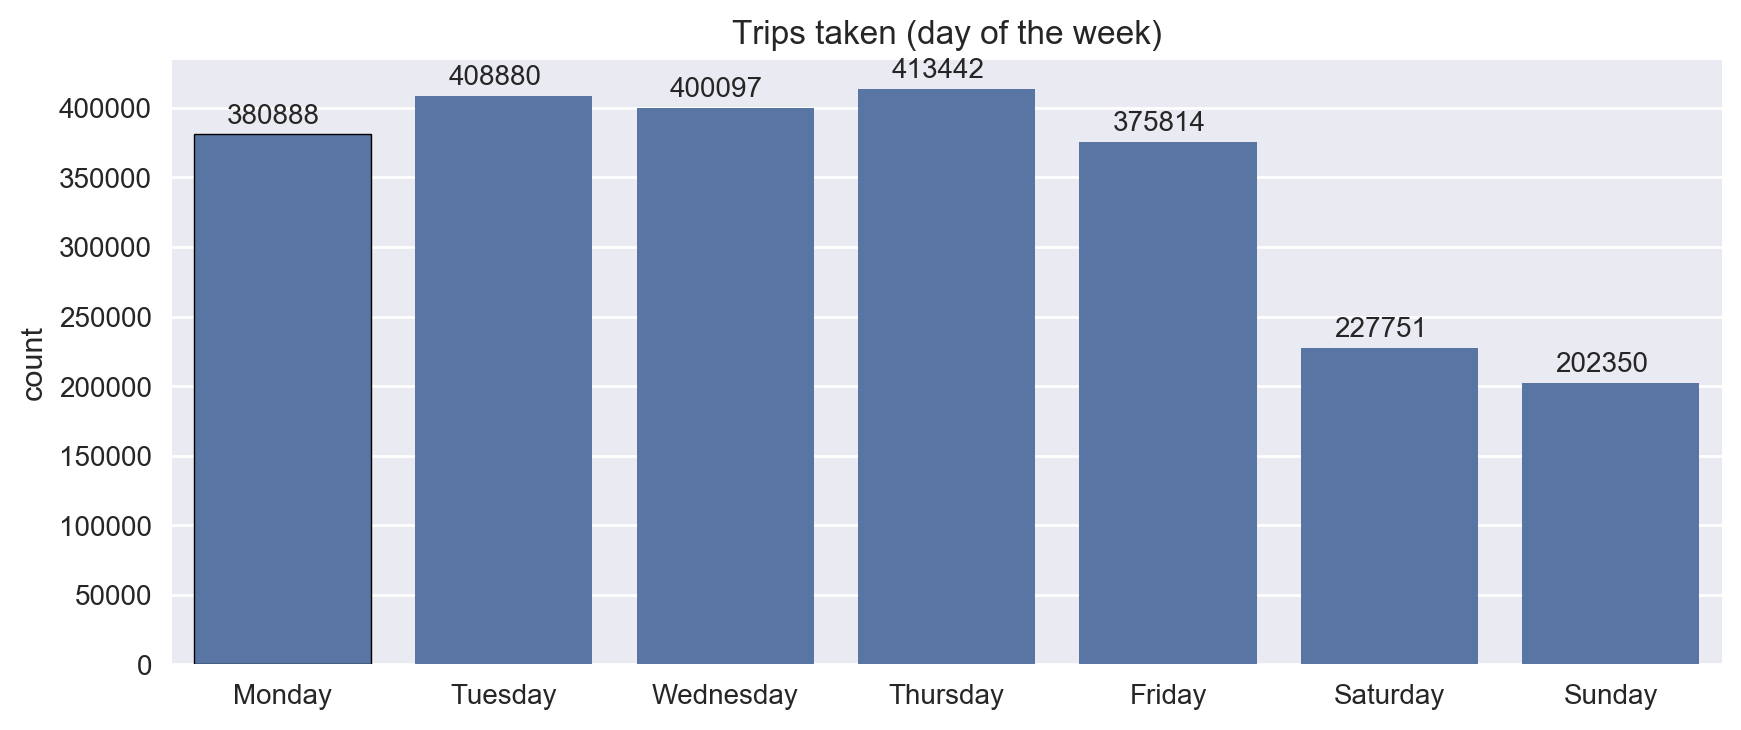

In [370]:
fig, axes = plt.subplots(figsize = (10,4), dpi = 100)
sns.barplot(data = df_weekday, x= 'index',y='count', color= sns.color_palette()[0],lw = 0.5, edgecolor = "black")
cur_axes = plt.gca()
cur_axes.axes.get_yaxis()
cur_axes.axes.get_xaxis().set_label_text('')
sns.despine(fig, left = True)

for p in axes.patches:
    axes.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+ 8000))

plt.title('Trips taken (day of the week)'); 

- We can see from the plot that Tuesday to Friday has the most trips taken, followed by Monday and Friday. Trips in  Saturday and Sunday are approximately half of the rides than in weekdays. 

**When are most trips taken in terms of time of the day?**

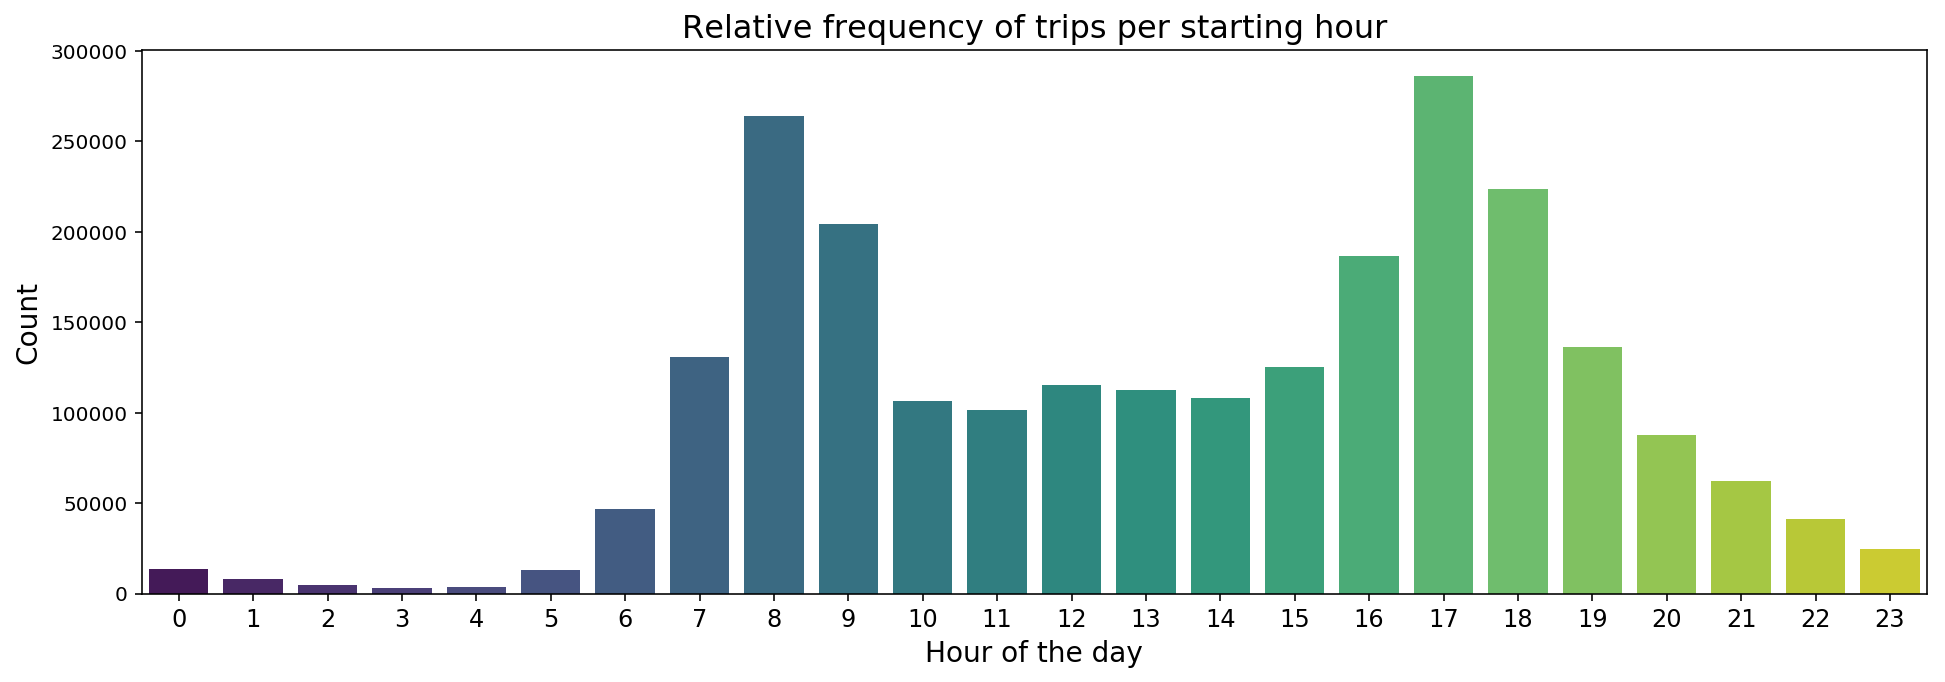

In [30]:
fig, ax = plt.subplots(figsize = (16,5))
sns.countplot(x = "start_hour", data = df, palette = "viridis")
plt.title("Relative frequency of trips per starting hour", fontsize= 16)
plt.xlabel('Hour of the day', fontsize =14)
plt.ylabel('Count',fontsize =14)
plt.xticks( fontsize =12);

The most frequent starting hours are at commute peak time 8 and at 17. Lets see if this pattern is specially for weekday. 


**Are there any peak time of rides in terms day of the week and hours of the day? **

In [31]:
# create bins and cut the hours into 6 bins 
bin_hour = 4
bins_edges = np.arange(0, df['start_hour'].max()+bin_hour , bin_hour)
df['start_hour_binned'] = pd.cut(df['start_hour'], bins_edges, include_lowest = True)

In [32]:
# create a dataframe with grouped by start_hour_binned and start_weekday 
df_grouped_hr = df.groupby(['start_hour_binned','start_weekday']).size().reset_index(name='count')
df_grouped_hr.start_hour_binned = df_grouped_hr.start_hour_binned.astype(str)

In [33]:
# clean up the hour bin infromation 
df_grouped_hr.start_hour_binned =\
df_grouped_hr.start_hour_binned.apply(lambda x: x.split(",")[0].strip('()').strip('.').replace(".0","")) + '-'+\
df_grouped_hr.start_hour_binned.apply(lambda x: x.split(",")[1].strip('(] ').strip('.').replace(".0",""))

df_grouped_hr.loc[df_grouped_hr.start_hour_binned =='-001-4','start_hour_binned'] = "0-4"

In [40]:
# create a pivot table to create heatmap 
heatmap_df = df_grouped_hr.pivot(index = 'start_hour_binned', columns ='start_weekday', values= 'count')

# Reorder the start_hour 
heatmap_df = heatmap_df.loc[['0-4', '4-8', '8-12', '12-16', '16-20', '20-24'], :]

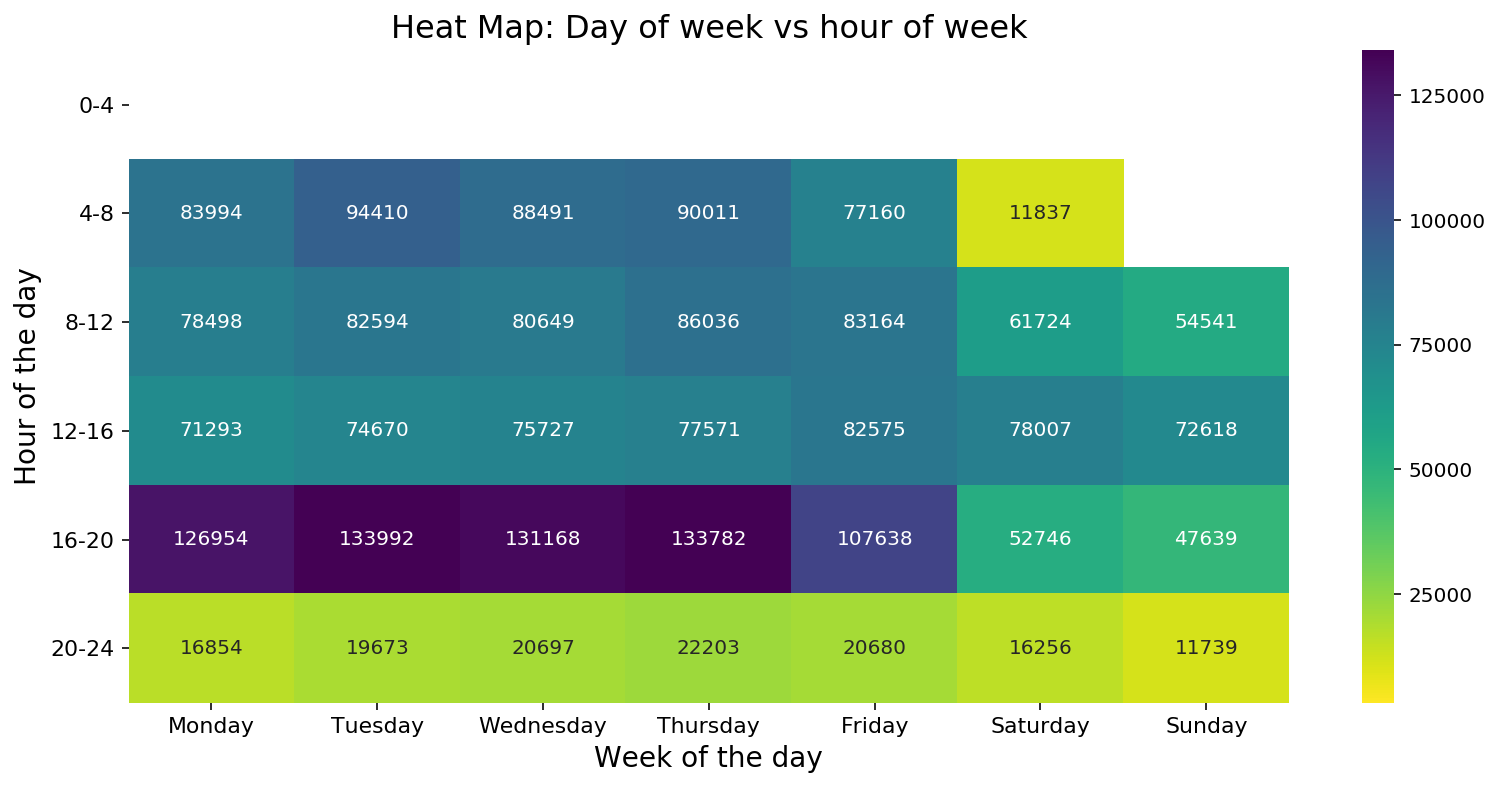

In [58]:
plt.figure(figsize= (13,6))
sns.heatmap(heatmap_df,
            # add annotation 
            annot = True, 
            # all the counts are listed as decimal values can use fmt ='.0f' if we have any cells with no counts
            fmt = 'd', cmap ='viridis_r', mask = (heatmap_df<= 10000))
plt.title("Heat Map: Day of week vs hour of week", fontsize= 16)
plt.xlabel('Week of the day', fontsize =14)
plt.ylabel('Hour of the day',fontsize =14)
plt.xticks( fontsize =11)
plt.yticks( rotation = 0, fontsize =11);

- We can see that oveall people turns to take rides more on Weekday commute time (16-20pm and 8:12am). This pattern is not that obvious during weekend. 

## Multivariate Exploration

Now, lets introduce another variable user_type to see if user have different ride habit of in case of the riding duration in different month.    

**Can we find any interesting riding behaviours between Customer and Subscribe**

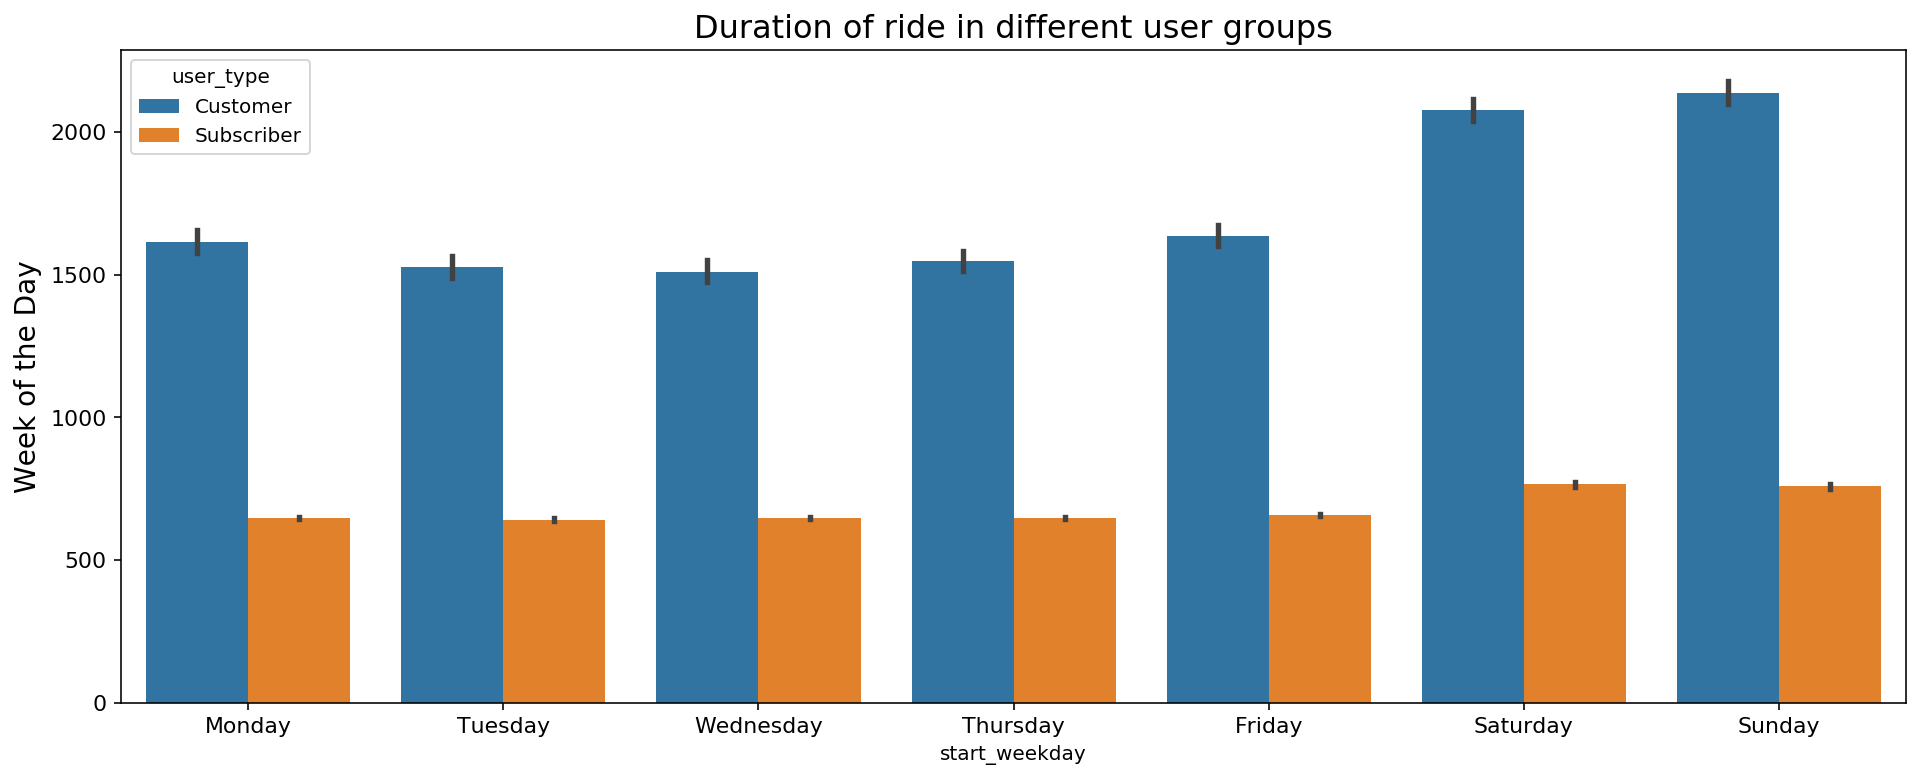

In [67]:
plt.figure(figsize =(16,6)) 
base_color = sns.color_palette()[0]
sns.barplot(data= df, x ='start_weekday', y='duration_sec', hue ='user_type' )  
plt.ylabel("Duration Sec ",  fontsize =14)
plt.ylabel("Week of the Day",  fontsize =14)
plt.title("Duration of ride in different user groups", fontsize= 16)

plt.xticks( fontsize =11)
plt.yticks(fontsize =11);

- We can see that most compared to non-subscribed customer group, the subscribed customer group turns to have ride in slight difference of each day of week and the average ride time is lower. 

**Can we find any patterns in terms of month?**

In [68]:
df['year_month'] = df.start_time.apply(lambda x: str(x)[:7])

In [69]:
df_sample = df.sample(10000).sort_values(by='year_month')

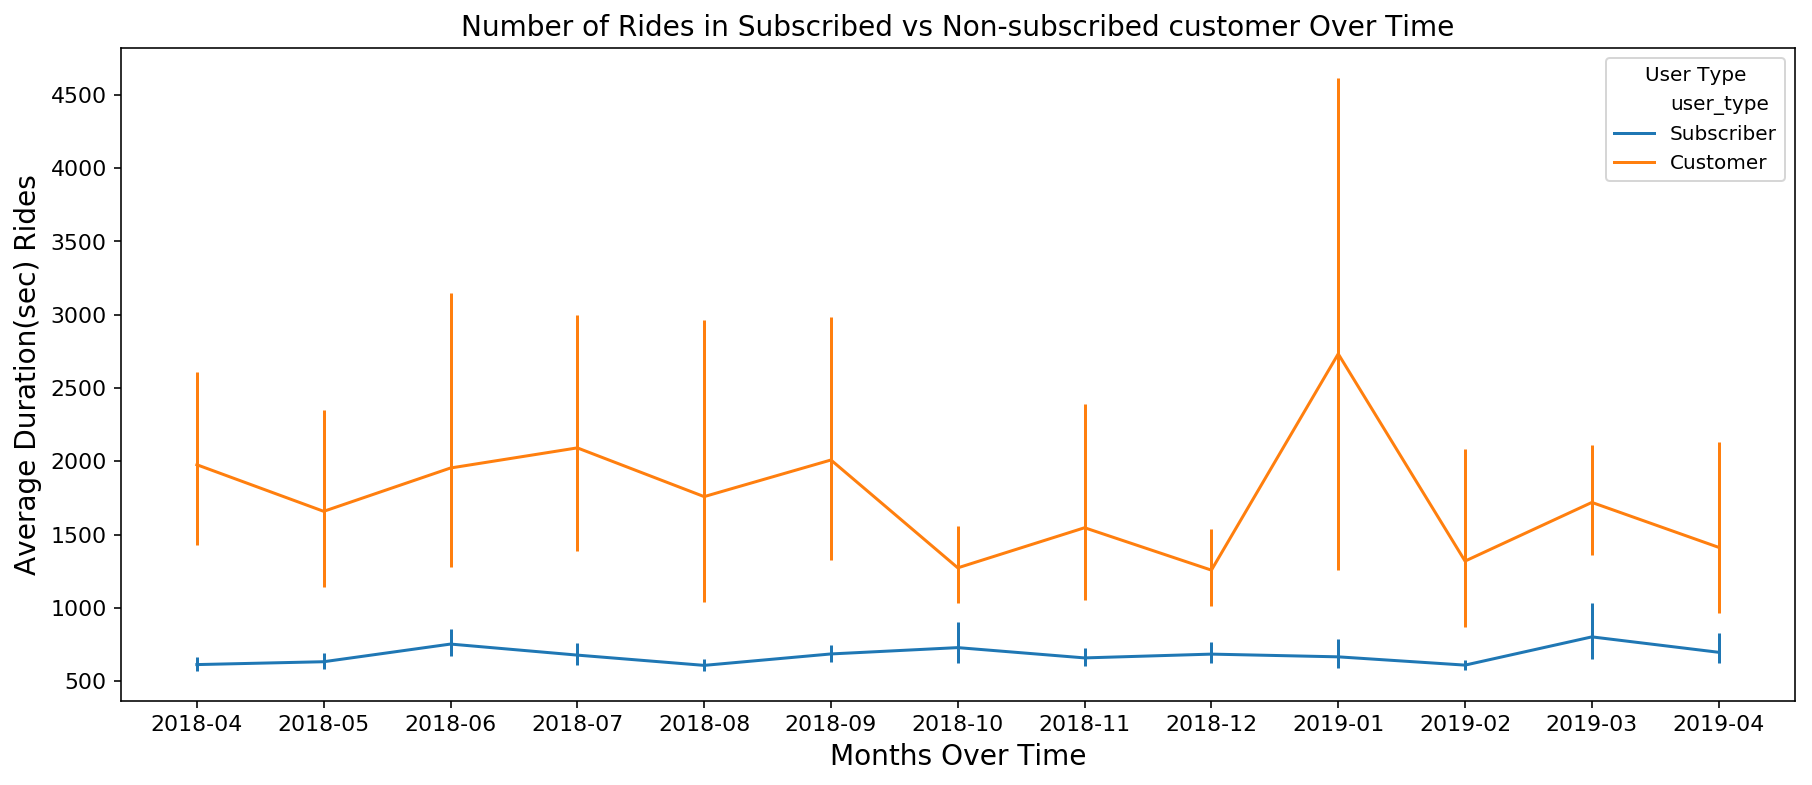

In [77]:
plt.figure(figsize=(15,6))
sns.lineplot(data = df_sample, x = 'year_month', y = 'duration_sec', markers=True, hue = 'user_type',err_style="bars");
plt.title('Number of Rides in Subscribed vs Non-subscribed customer Over Time', fontsize = 14)
plt.legend(title = 'User Type')
plt.xlabel('Months Over Time',fontsize= 14)
plt.ylabel('Average Duration(sec) Rides',fontsize= 14)

plt.xticks( fontsize =11)
plt.yticks(fontsize =11);

We can see that for the subscriber, the the average ride time is more stable over time while the people turn to ride less on certain months, this may due to the weather issue.

**Can we find similar patterns in terms of Routes Type (Commute/normal)?**

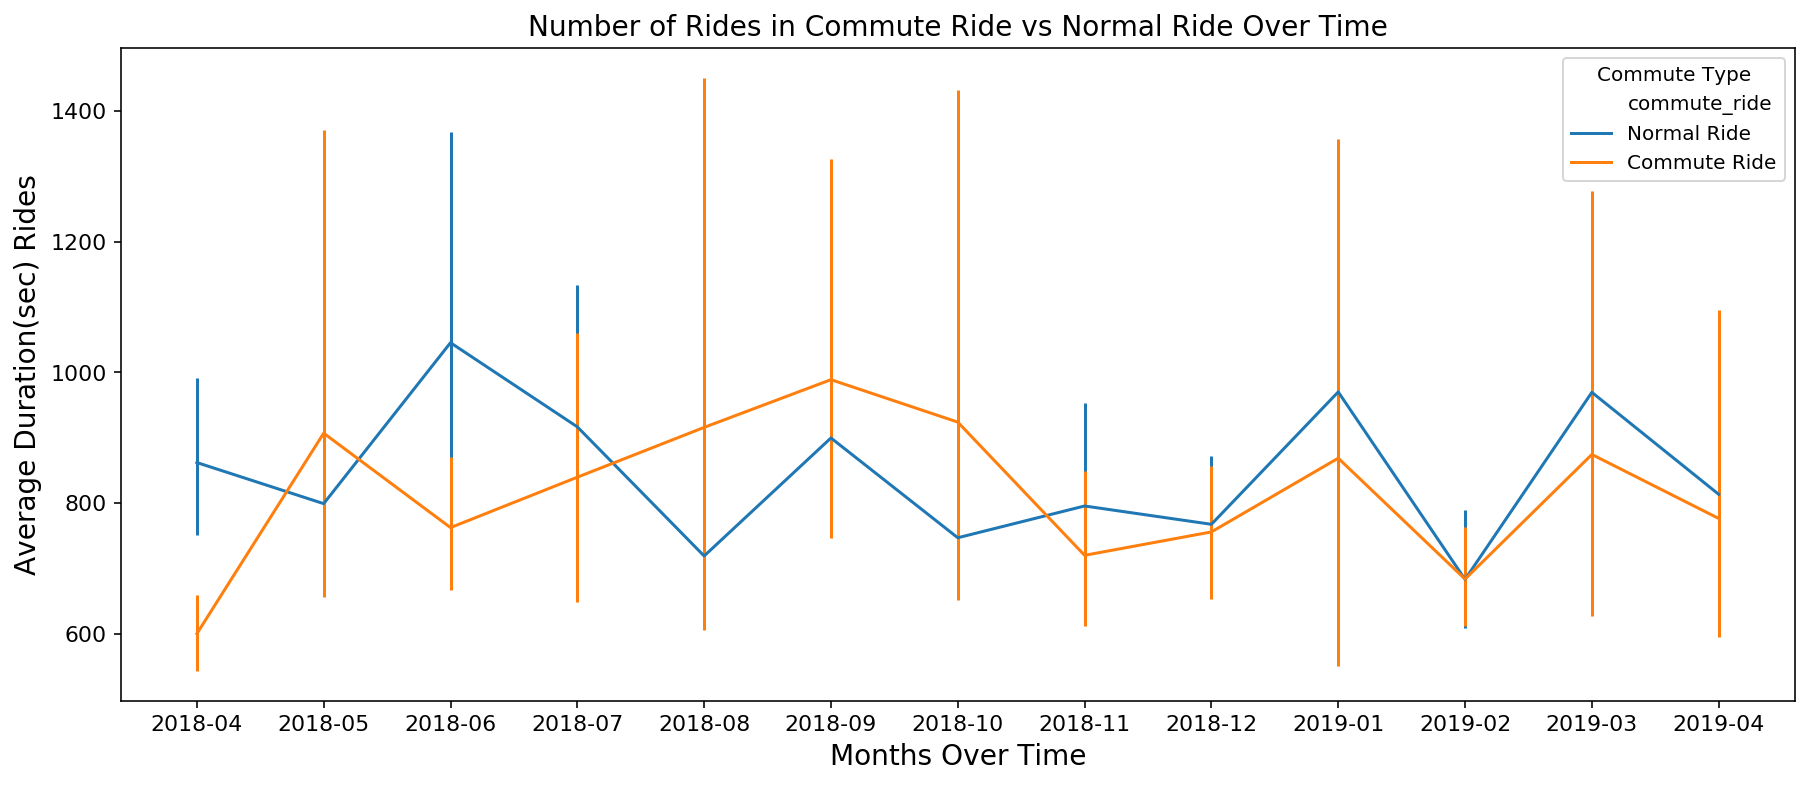

In [76]:
plt.figure(figsize=(15,6))
sns.lineplot(data = df_sample, x = 'year_month', y = 'duration_sec', markers=True, hue = 'commute_ride',err_style="bars");
plt.title('Number of Rides in Commute Ride vs Normal Ride Over Time', fontsize = 14)
plt.legend(title = 'Commute Type')
plt.xlabel('Months Over Time', fontsize =14)
plt.ylabel('Average Duration(sec) Rides',fontsize= 14)

plt.xticks( fontsize =11)
plt.yticks(fontsize =11);

This is really unexpected. We found in previous Bivariate visualization analysis that people who take communite ride has an overall more standard duration of ride while if we look this graph by month over month, we found it fluctures a lot. So we may conclude that user type is more important issue to predict the average durcation of rides. 